In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os

pd.options.mode.chained_assignment = None

In [5]:
DIR = os.getcwd()

# raw data
RAW = "\data\\raw"
PATH_DF_TIMESERIES = DIR + RAW + '\\df_timeseries_en.tsv.gz' # 571 mb

# clean data
CLEAN = "\data\\clean"
PATH_TECH_CHANNELS = DIR + CLEAN + '\\tech_review_channels.tsv.gz'
PATH_TECH_VIDEOS = DIR + CLEAN + '\\tech_review_videos.tsv.gz'

In [6]:
keywords = {
    'laptop':['laptop','macbook','zenbook','vivobook','chromebook','aspire','inspiron','legion','macos','ram','cpu','monitor','keyboard','mouse','linux','windows'],
    'phone':['mobile','phone','smartphone','cellphone','verizon','iphone','android','galaxy','pixel','oneplus','ios','case','nexus','redmi','reno','nokia','htc','realme'],
    'camera':['camera','dslr','mirrorless','canon','nikon','sony','fujifilm','gopro','aperture','shutter','iso','tripod','lens','portrait']
}

In [7]:
tech_review_videos = pd.read_csv(PATH_TECH_VIDEOS, compression="infer", sep="\t")
tech_review_channels = pd.read_csv(PATH_TECH_CHANNELS, compression="infer", sep="\t")

# EDA

In [8]:
"""
from ydata_profiling import ProfileReport

# Produce and save the profiling report
profile = ProfileReport(tech_review_videos,title="Tech Channels Profile Report")
profile.to_file("report.html")
""";

In [9]:
def classify_product(title, keywords):
    count = {}
    for keyword in keywords:
        count[keyword] = sum([word in title for word in keywords[keyword]])
    if len(count) != 0:
        return max(count, key=count.get)
    else:
        return np.nan

In [12]:
tech_df = pd.merge(tech_review_channels,tech_review_videos,on='channel_id',how='left')

In [13]:
tech_df.columns

Index(['join_date', 'channel_id', 'name_cc', 'subscribers_cc', 'videos_cc',
       'subscriber_rank_sb', 'weights', 'count_tech_videos', 'dislike_count',
       'display_id', 'duration', 'like_count', 'tags', 'title', 'upload_date',
       'view_count', 'num_comms', 'clean_title', 'clean_tags'],
      dtype='object')

In [14]:
tech_df.sort_values(by='subscribers_cc',ascending=False).name_cc.unique()

array(['Unbox Therapy', 'Technical Guruji', 'CrazyRussianHacker', ...,
       'Full Speed PC', 'Ur PointOfTech', 'FocusCamera TV'], dtype=object)

In [15]:
focus_camera_tv = tech_df[tech_df.name_cc=='FocusCamera TV']
focus_camera_tv['product_category'] = focus_camera_tv.title.apply(lambda title: classify_product(title.lower(), keywords))
focus_camera_tv.groupby('product_category')[['display_id']].count()

,display_id
product_category,
camera,37
laptop,4
phone,1


In [16]:
tech_dad = tech_df[tech_df.name_cc=='Tech Dad']
tech_dad['product_category'] = tech_dad.title.apply(lambda title: classify_product(title.lower(), keywords))
tech_dad.groupby('product_category')[['display_id']].count()

,display_id
product_category,
camera,545
laptop,11
phone,3334


In [51]:
unbox_therapy = tech_df[tech_df.name_cc=='Unbox Therapy']
unbox_therapy['product_category'] = unbox_therapy.title.apply(lambda title: classify_product(title.lower(), keywords))
unbox_therapy.groupby('product_category')[['display_id']].count()

,display_id
product_category,
camera,25
laptop,192
phone,189


In [52]:
unbox_therapy[unbox_therapy.product_category.isna()]

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_comms,clean_title,clean_tags,product_category


In [53]:
unbox_therapy['upload_year'] = pd.to_datetime(unbox_therapy.upload_date).dt.year

Text(0.5, 1.0, 'Number of videos percentage per category')

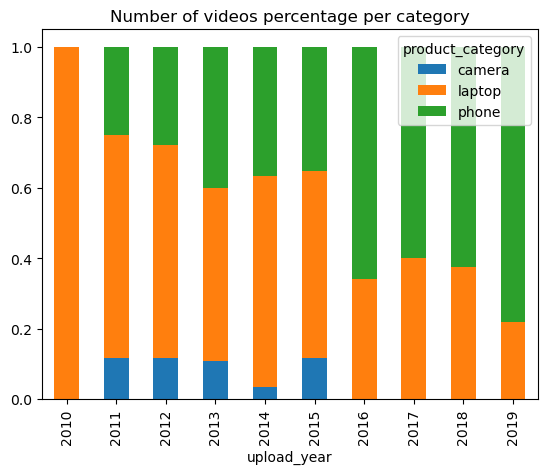

In [59]:
num_videos_year = unbox_therapy.groupby(['upload_year'],as_index=False)[['display_id']].count()
num_videos_category = unbox_therapy.groupby(['upload_year','product_category'],as_index=False)[['display_id']].count()
num_videos = pd.merge(num_videos_year,num_videos_category,on='upload_year',how='left')
num_videos['videos_perc'] = num_videos['display_id_y'] / num_videos['display_id_x']
num_videos = num_videos.pivot(index='upload_year',columns='product_category',values='videos_perc').fillna(0)

num_videos.plot(kind='bar',stacked=True)

plt.title('Number of videos percentage per category')

Text(0.5, 1.0, 'Number of view percentage per category')

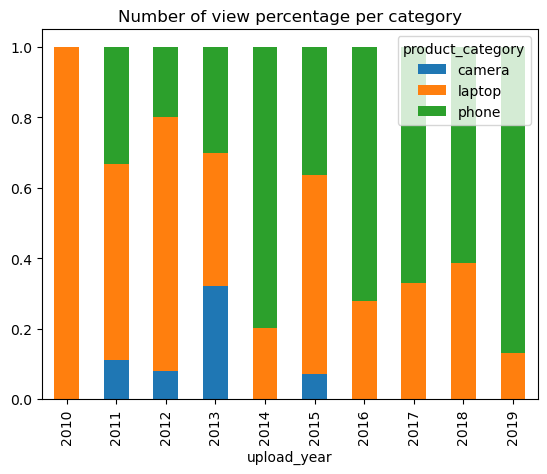

In [58]:
view_count_year = unbox_therapy.groupby(['upload_year'],as_index=False)[['view_count']].sum()
view_count_category = unbox_therapy.groupby(['upload_year','product_category'],as_index=False)[['view_count']].sum()
view_count = pd.merge(view_count_year,view_count_category,on='upload_year',how='left')
view_count['view_count_perc'] = view_count['view_count_y'] / view_count['view_count_x']
view_count = view_count.pivot(index='upload_year',columns='product_category',values='view_count_perc').fillna(0)

view_count.plot(kind='bar',stacked=True)

plt.title('Number of view percentage per category')

In [68]:
num_videos_category_pivot = num_videos_category.pivot(index='upload_year',columns='product_category',values='display_id').fillna(0)
view_count_category_pivot = view_count_category.pivot(index='upload_year',columns='product_category',values='view_count').fillna(0)
view_ratio = view_count_category_pivot / num_videos_category_pivot
view_ratio.fillna(0,inplace=True)

Text(0.5, 1.0, 'number of views / number of videos')

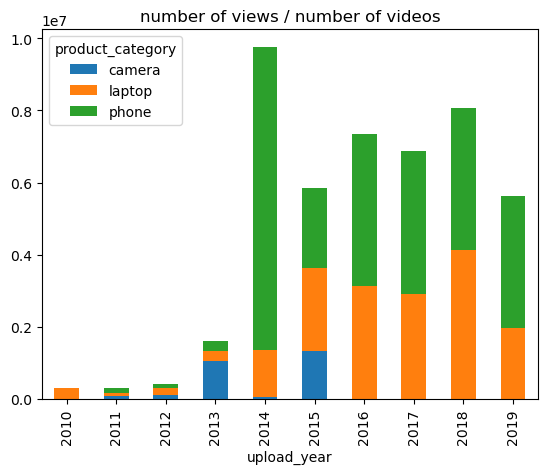

In [69]:
view_ratio.plot(kind='bar',stacked=True)
plt.title('number of views / number of videos')

Text(0.5, 1.0, 'percentage of number of views / number of videos')

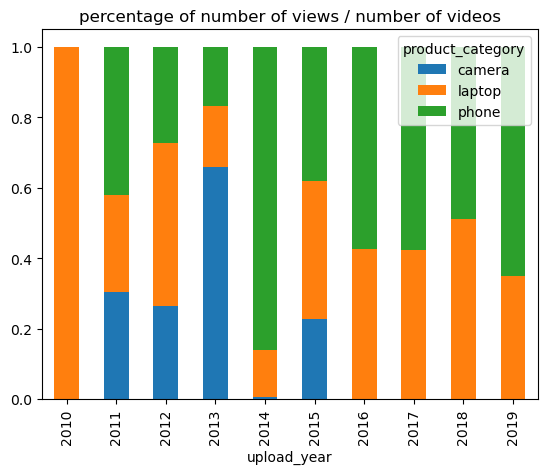

In [80]:
view_ratio.divide(view_ratio.sum(axis=1),axis=0).plot(kind='bar',stacked=True)
plt.title('percentage of number of views / number of videos')

# 2013 and 2014

In [88]:
unbox_therapy_2013 = unbox_therapy[unbox_therapy.upload_year==2013]
unbox_therapy_2013['month'] = pd.to_datetime(unbox_therapy_2013.upload_date).dt.month
unbox_therapy_2013.shape

(55, 22)

Text(0.5, 1.0, 'percentage of number of views / number of videos in 2013')

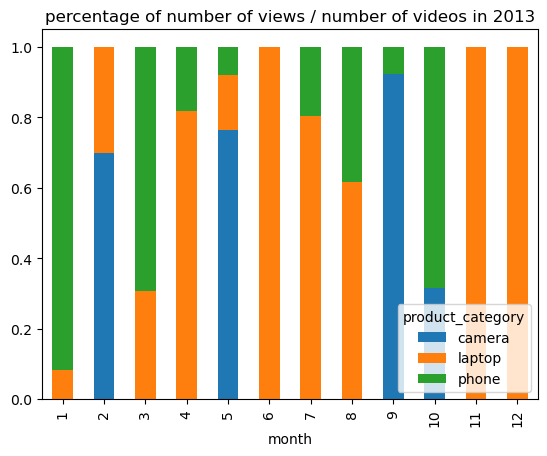

In [89]:
num_videos_2013_category = unbox_therapy_2013.groupby(['month','product_category'],as_index=False)[['display_id']].count()
view_count_2013_category = unbox_therapy_2013.groupby(['month','product_category'],as_index=False)[['view_count']].sum()

num_videos_2013_category_pivot = num_videos_2013_category.pivot(index='month',columns='product_category',values='display_id').fillna(0)
view_count_2013_category_pivot = view_count_2013_category.pivot(index='month',columns='product_category',values='view_count').fillna(0)

view_ratio_2013 = view_count_2013_category_pivot / num_videos_2013_category_pivot
view_ratio_2013.fillna(0,inplace=True)

view_ratio_2013.divide(view_ratio_2013.sum(axis=1),axis=0).plot(kind='bar',stacked=True)
plt.title('percentage of number of views / number of videos in 2013')